In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# 1) Importations

In [2]:
%pylab inline
import pandas as pd
import os
import seaborn as sns
import math
from sklearn import preprocessing
import pickle
from dateutil import parser

Populating the interactive namespace from numpy and matplotlib


In [3]:
def display_progress_bar(n_tot, n_prog) :
    from time import sleep
    progress = math.ceil((n_prog + 1) * 100 / n_tot)
    sys.stdout.write('\r')
    sys.stdout.write("[%-100s] %d%%" %('='*progress, progress))
    sys.stdout.flush()
    sleep(0.25)

# 2) Gathering 2016 data from monthly divided files

In [4]:
features_data = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'TAIL_NUM', 'UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_AIRPORT_ID',
                 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'ARR_DELAY_NEW', 'DISTANCE']

In [5]:
data_2016 = pd.DataFrame(columns=features_data)

In [6]:
# Getting current path
path = os.getcwd()
data_files = [file for file in os.listdir(path + '/data') if file.startswith('2016_')]

In [7]:
try :
    data_2016 = pd.read_csv(path + "/data/data_2016.csv", sep=',')
    print("Loading 2016 full dataset")
except :
    for file in data_files :
        print("Treating file : %s" % file)
        # Verifying data presence
        # Initializing rows to skip
        pb_entries = []
        try_again = True
        while try_again :
            try :
                data_month = pd.read_csv(path + "/data/" + file, sep=',', skiprows=pb_entries)
                try_again = False
            except FileNotFoundError :
                print("Please check if the file %s is in the 'data' folder at the current location" % file)
            except pd.errors.ParserError as e:
                error = str(e)
                pb_entries.append(int(error.split("in line ",1)[1].split(", ",1)[0]) - 1)
                
        # Select features
        data_month = data_month.loc[:, features_data]
        # Drop missing columns
        data_month = data_month.dropna(axis='columns', how='all')
        # Drop duplicates
        data_month = data_month.drop_duplicates(keep='first')

        # Save month data
        data_2016 = data_2016.append(data_month)
    
    # Last duplicates check
    data_2016 = data_2016.drop_duplicates(keep='first')

    # Save data
    print("Saving")
    data_2016.to_csv("data/data_2016.csv", index=False)

Loading 2016 full dataset


# 3) Cleaning

# 3.1) Duplicates and missing values

In [8]:
# Getting rid of the duplicates
print("initial shape : ", data_2016.shape)
dup = data_2016[data_2016.duplicated()].shape[0]
if dup > 0 :
    print("duplicates found : ", dup)
    data_2016 = data_2016.drop_duplicates(keep='first')
    print("Shape without duplicates: ", data_2016.shape)
else :
    print("No duplicate")

initial shape :  (5518859, 14)
No duplicate


In [9]:
# Looking for missing values
missing_val_df = data_2016.isnull().sum(axis=0).reset_index()
missing_val_df.columns = ['feature', 'missing values']
missing_val_df['missing values (%)']=100 - ((data_2016.shape[0]-missing_val_df['missing values'])/data_2016.shape[0]*100)
missing_val_df = missing_val_df.sort_values('missing values (%)', ascending=False)
missing_val_df

,feature,missing values,missing values (%)
12,ARR_DELAY_NEW,78710,1.426201
4,TAIL_NUM,12728,0.230627
13,DISTANCE,3,0.000054
11,CRS_ARR_TIME,2,0.000036
0,MONTH,0,0.000000
1,DAY_OF_MONTH,0,0.000000
2,DAY_OF_WEEK,0,0.000000
3,FL_DATE,0,0.000000
5,UNIQUE_CARRIER,0,0.000000
6,ORIGIN,0,0.000000


So many datapoints : we allow ourselves to delete these missing values

In [10]:
# Delete for missing values
data_2016 = data_2016.dropna()
data_2016.isnull().sum()

MONTH                0
DAY_OF_MONTH         0
DAY_OF_WEEK          0
FL_DATE              0
TAIL_NUM             0
UNIQUE_CARRIER       0
ORIGIN               0
ORIGIN_AIRPORT_ID    0
ORIGIN_CITY_NAME     0
DEST_AIRPORT_ID      0
CRS_DEP_TIME         0
CRS_ARR_TIME         0
ARR_DELAY_NEW        0
DISTANCE             0
dtype: int64

# 3.2) Feature engineering

In [11]:
data_2016.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,TAIL_NUM,UNIQUE_CARRIER,ORIGIN,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY_NEW,DISTANCE
0,1,6,3,2016-01-06,N4YBAA,AA,DFW,11298,"Dallas/Fort Worth, TX",11433.0,1100.0,1438.0,0.0,986.0
1,1,7,4,2016-01-07,N434AA,AA,DFW,11298,"Dallas/Fort Worth, TX",11433.0,1100.0,1438.0,0.0,986.0
2,1,8,5,2016-01-08,N541AA,AA,DFW,11298,"Dallas/Fort Worth, TX",11433.0,1100.0,1438.0,7.0,986.0
3,1,9,6,2016-01-09,N489AA,AA,DFW,11298,"Dallas/Fort Worth, TX",11433.0,1100.0,1438.0,0.0,986.0
4,1,10,7,2016-01-10,N439AA,AA,DFW,11298,"Dallas/Fort Worth, TX",11433.0,1100.0,1438.0,113.0,986.0


In [12]:
# Build complete time format
print("Getting time data")
date_df = data_2016.loc[:, ['FL_DATE', 'CRS_DEP_TIME']]
date_df['HOUR'] = date_df.loc[:, 'CRS_DEP_TIME'].apply(lambda x : math.trunc(x / 100))
date_df['MINUTES'] = date_df.loc[:, 'CRS_DEP_TIME'].apply(lambda x : int(x % 100))
print("Concatenating time data")
date_df['DATETIME'] = date_df.loc[:, 'FL_DATE'] + "T" + date_df.loc[:, 'HOUR'].apply(str) + ":" + date_df.loc[:, 'MINUTES'].apply(str)
print("Parsing time data")
data_2016.loc[:, 'DATE_TIME'] = date_df.loc[:, 'DATETIME'].apply(parser.parse)

# Remove full date
data_2016 = data_2016.drop('FL_DATE', axis=1)

Getting time data
Concatenating time data
Parsing time data


Converting departure and arrival time in seconds

In [13]:
def func(date_time) :
    """
    Routine converting time of day to number of seconds
    """
    seconds = date_time.hour * 3600 + date_time.minute * 60 + date_time.second
    return seconds

In [14]:
data_2016.loc[:, 'TIME_SECONDS'] = data_2016.loc[:, 'DATE_TIME'].apply(func)

In [15]:
data_2016.loc[:, 'ARR_TIME_SECS'] = data_2016.loc[:, 'CRS_ARR_TIME'].apply(lambda x : (x/100)*3600 + x%100*60)

In [16]:
# Sort data by date and time
data_2016 = data_2016.sort_values(by=['DATE_TIME'])

# 4) Exploration

In [17]:
categ_feat = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'TAIL_NUM', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']
num_feat = ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'ARR_DELAY_NEW', 'DISTANCE', 'DATE_TIME']

In [18]:
data_2016_explo = data_2016.copy()

Mean delay as a function of the categorical features

In [19]:
# Initialize dict of feature(feature values, mean of delay for those values)
mean_delays_categ = {}
for feat in categ_feat :
    print(feat)
    # Get mean serie grouped by feature
    feat_mean_serie = data_2016_explo['ARR_DELAY_NEW'].groupby(data_2016_explo[feat]).apply(lambda x : x.mean())
    # Save values of features
    mean_delays_categ[feat] = [feat_mean_serie.index.values.tolist()]
    # Save means of values of features
    mean_delays_categ[feat].append(feat_mean_serie.values.tolist())

MONTH
DAY_OF_MONTH
DAY_OF_WEEK
UNIQUE_CARRIER
TAIL_NUM
ORIGIN_AIRPORT_ID
DEST_AIRPORT_ID


Mean delay as a function of the numerical features

In [20]:
# Initialize dict of feature(feature values, mean of delay for those values)
mean_delays_num = {}
for feat in num_feat :
    print(feat)
    # Get mean serie grouped by feature
    feat_mean_serie = data_2016_explo['ARR_DELAY_NEW'].groupby(data_2016_explo[feat]).apply(lambda x : x.mean())
    # Save values of features
    mean_delays_num[feat] = [feat_mean_serie.index.values.tolist()]
    # Save means of values of features
    mean_delays_num[feat].append(feat_mean_serie.values.tolist())

CRS_DEP_TIME
CRS_ARR_TIME
ARR_DELAY_NEW
DISTANCE
DATE_TIME


Airports

Construct dictionnary of airports names for later use

In [21]:
ap_df = data_2016_explo.loc[:,['ORIGIN_AIRPORT_ID','ORIGIN','ORIGIN_CITY_NAME']].drop_duplicates(subset=['ORIGIN_AIRPORT_ID'], keep='first')
# Get airports initials
airport_initials = ap_df.loc[:,'ORIGIN'].values
# Get airports full names
airport_names = ap_df.loc[:,'ORIGIN_CITY_NAME'].values
# Get airports encoded values
airport_number = ap_df.loc[:,'ORIGIN_AIRPORT_ID'].values
# Save dict
airport_dict = dict(zip(airport_number, airport_initials))
airport_dict_name = dict(zip(airport_number, airport_names))

Number of different airports ?

In [22]:
n_dep_ap = data_2016_explo.loc[:,'ORIGIN_AIRPORT_ID'].unique().shape[0]
n_arr_ap = data_2016_explo.loc[:,'DEST_AIRPORT_ID'].unique().shape[0]
print("%i origin airports and %i destination airports" % (n_dep_ap, n_arr_ap))

311 origin airports and 310 destination airports


Most frequented airports

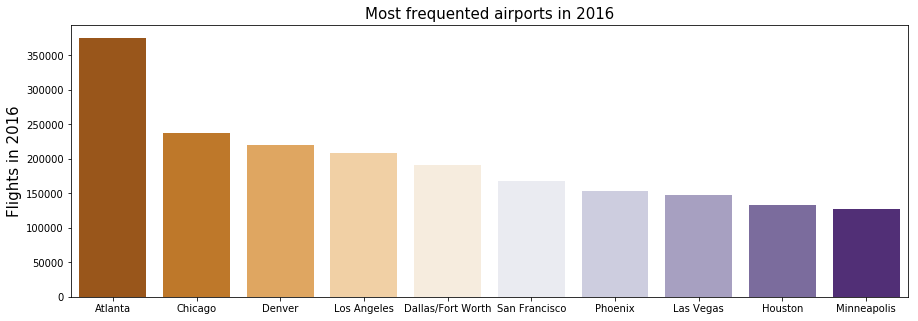

In [23]:
# Get 10 biggest airports
ap_flights_counts = data_2016_explo.loc[:,'ORIGIN'].value_counts().head(10)
ap_numbers = data_2016_explo.loc[:,'ORIGIN_AIRPORT_ID'].value_counts().head(10).index.values
ap_names = []
for number in ap_numbers :
    ap_names.append(airport_dict_name[number].split(",")[0])
# Plot
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(ap_flights_counts.index.values, ap_flights_counts.values, palette='PuOr')
ax.set_xticklabels(ap_names, fontsize=10)
ax.set_title("Most frequented airports in 2016", loc="center", fontsize=15)
ax.set_ylabel("Flights in 2016", fontsize=15);

Least frequented airports

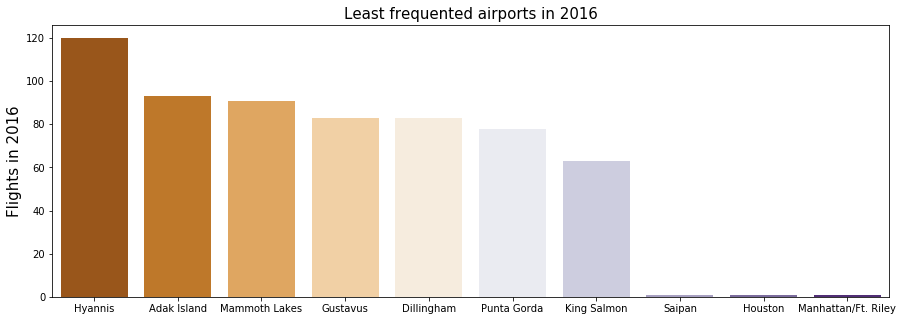

In [24]:
# Get 10 smallest airports
ap_flights_counts = data_2016_explo.loc[:,'ORIGIN'].value_counts().tail(10)
ap_numbers = data_2016_explo.loc[:,'ORIGIN_AIRPORT_ID'].value_counts().tail(10).index.values
ap_names = []
for number in ap_numbers :
    ap_names.append(airport_dict_name[number].split(",")[0])
# Plot
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(ap_flights_counts.index.values, ap_flights_counts.values, palette='PuOr')
ax.set_xticklabels(ap_names, fontsize=10)
ax.set_ylabel("Flights in 2016", fontsize=15)
ax.set_title("Least frequented airports in 2016", loc="center", fontsize=15);

Some airports have very few flights over the year, some have a lot : we wont consider those with too few flights because of their poor statistic

In [25]:
# Setting lower limit of airports flights
flights_low = 1000

Number of departure airports with 1000 or less flights per year : 88


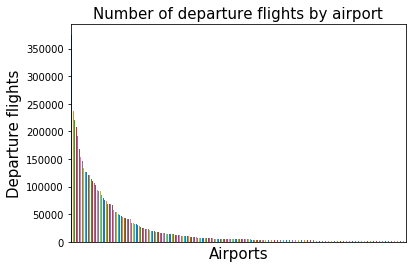

In [26]:
freq_dep_ap = data_2016_explo.loc[:,'ORIGIN_AIRPORT_ID'].value_counts()
print("Number of departure airports with %i or less flights per year : %i" % (flights_low, 
                                                                              freq_dep_ap[freq_dep_ap <= flights_low].shape[0]))
# Saving small airports for later removal
small_dep_ap = freq_dep_ap[freq_dep_ap < flights_low].index.values

# Bar plot
freq_dep_ap[freq_dep_ap >= flights_low].plot.bar()
axes = plt.gca()
axes.get_xaxis().set_ticks([])
axes.set_xlabel("Airports", fontsize=15)
axes.set_ylabel("Departure flights", fontsize=15)
axes.set_title("Number of departure flights by airport", fontsize=15);

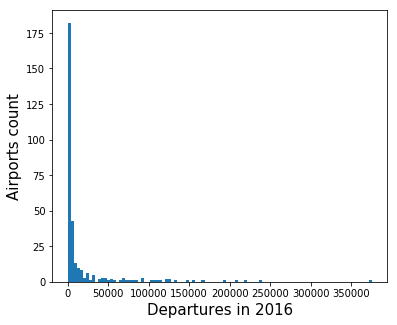

In [27]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(data_2016_explo.loc[:,'ORIGIN_AIRPORT_ID'].value_counts(), bins=100)
ax = plt.gca()
ax.set_xlabel("Departures in 2016", fontsize=15)
ax.set_ylabel("Airports count", fontsize=15);

Number of departure airports with 1000 or less flights per year : 87


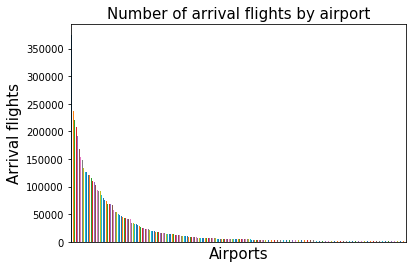

In [28]:
freq_arr_ap = data_2016_explo.loc[:,'DEST_AIRPORT_ID'].value_counts()
print("Number of departure airports with %i or less flights per year : %i" % (flights_low, 
                                                                              freq_arr_ap[freq_arr_ap <= flights_low].shape[0]))
# Saving small airports for later removal
small_arr_ap = freq_arr_ap[freq_arr_ap < flights_low].index.values

# Bar plot
freq_arr_ap[freq_arr_ap >= flights_low].plot.bar()
axes = plt.gca()
axes.get_xaxis().set_ticks([])
axes.set_xlabel("Airports", fontsize=15)
axes.set_ylabel("Arrival flights", fontsize=15)
axes.set_title("Number of arrival flights by airport", fontsize=15);

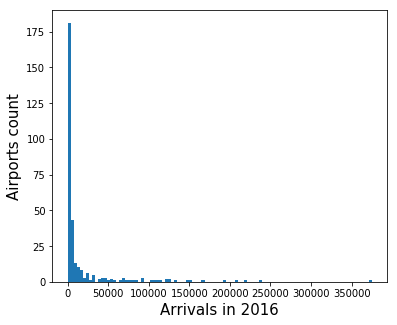

In [29]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(data_2016_explo.loc[:,'DEST_AIRPORT_ID'].value_counts(), bins=100)
ax = plt.gca()
ax.set_xlabel("Arrivals in 2016", fontsize=15)
ax.set_ylabel("Airports count", fontsize=15);

Airports with too few departures or arrivals may lead to biased models because of there small statistics, we will keep the airports with at least 1000 departures or arrivals per year, what we may do because of the high amount of entries in the dataset

In [30]:
print("Shape before removing small airports : %i" % data_2016_explo.shape[0])

# Check for small airports
small_dep = small_dep_ap
small_arr = small_arr_ap

# Loop
small_ap = small_dep.shape[0] + small_arr.shape[0]
while small_ap != 0 :
    data_2016_explo = data_2016_explo[~data_2016_explo.loc[:, 'ORIGIN_AIRPORT_ID'].isin(small_dep)]
    data_2016_explo = data_2016_explo[~data_2016_explo.loc[:, 'DEST_AIRPORT_ID'].isin(small_arr)]
    # Check again
    freq_dep_ap_temp = data_2016_explo.loc[:,'ORIGIN_AIRPORT_ID'].value_counts()
    small_dep = freq_dep_ap_temp[freq_dep_ap_temp < flights_low].index.values
    freq_arr_ap_temp = data_2016_explo.loc[:,'DEST_AIRPORT_ID'].value_counts()
    small_arr = freq_arr_ap_temp[freq_arr_ap_temp < flights_low].index.values
    # Loop
    small_ap = small_dep.shape[0] + small_arr.shape[0]
    
print("Shape after removing small airports : %i" % data_2016_explo.shape[0])

Shape before removing small airports : 5440148
Shape after removing small airports : 5341242


Airlines and delays : inspired from https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial/notebook#

In [31]:
# Airlines full names
airlines_full_names = {'AA' : 'American Airlines', 'AS' : 'Alaska Airlines', 'B6' : 'Jetblue Airways Corporation',
                       'DL' : 'Delta Air Lines, Inc.', 'EV' : 'ExpressJet Airlines', 'F9' : 'Frontier Airlines, Inc.',
                       'HA' : 'Hawaiian Airlines Inc.', 'NK' : 'Spirit Airlines, Inc.', 'OO' : ' Skywest Airlines',
                       'UA' : ' United Airlines, Inc.', 'VX' : 'Virgin America', 'WN' : 'Southwest Airlines'}
# Construct dictionnary of airlines names for later use
airlines_le = preprocessing.LabelEncoder()
# Get airlines names
airlines_names = data_2016_explo.loc[:,'UNIQUE_CARRIER'].value_counts().index.values
# Get airlines encoded values
airlines_number = airlines_le.fit_transform(airlines_names)
# Save dict
airlines_dict = dict(zip(airlines_number, airlines_names))

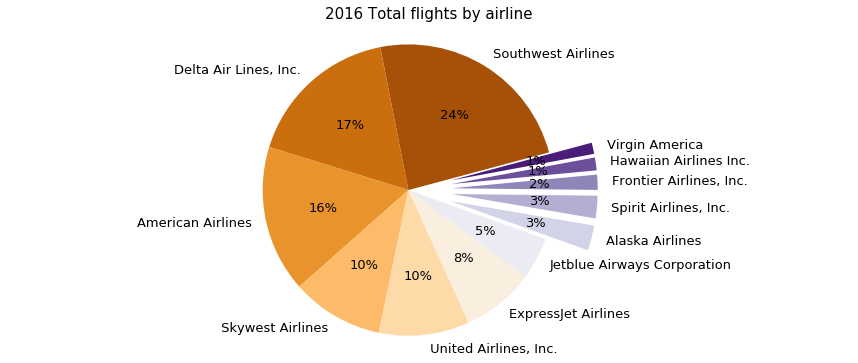

In [32]:
fig1, ax = plt.subplots(figsize=(15,6))
# Initialise flights DF
flights_df = pd.DataFrame()
# Total flights per airline
flights_df['flights'] = data_2016_explo.loc[:,'UNIQUE_CARRIER'].value_counts()
flights_df['flights_per'] = flights_df['flights'].apply(lambda x : x / flights_df['flights'].sum())
flights_df['init'] = flights_df.index.values
# Airline name and mean delay
flights_df['names'] = flights_df['init'].apply(lambda x : airlines_full_names[x])
flights_df['means'] = flights_df['init'].apply(lambda x : mean_delays_categ['UNIQUE_CARRIER'][1][mean_delays_categ['UNIQUE_CARRIER'][0].index(x)])
# Explode for small airlines
explode = [0.3 if flights_df['flights'].values[i] <= flights_df['flights'].sum()*4/100 else 0.0 for i in range(len(flights_df['flights'].values))]
# Pie chart
ax.pie(flights_df['flights'].values, labels=flights_df['names'].values, explode=explode, autopct='%.0f%%',
       textprops={'fontsize': 13}, startangle=15, colors=sns.color_palette("PuOr", 12))
ax.axis('equal');  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('2016 Total flights by airline', fontsize=15);

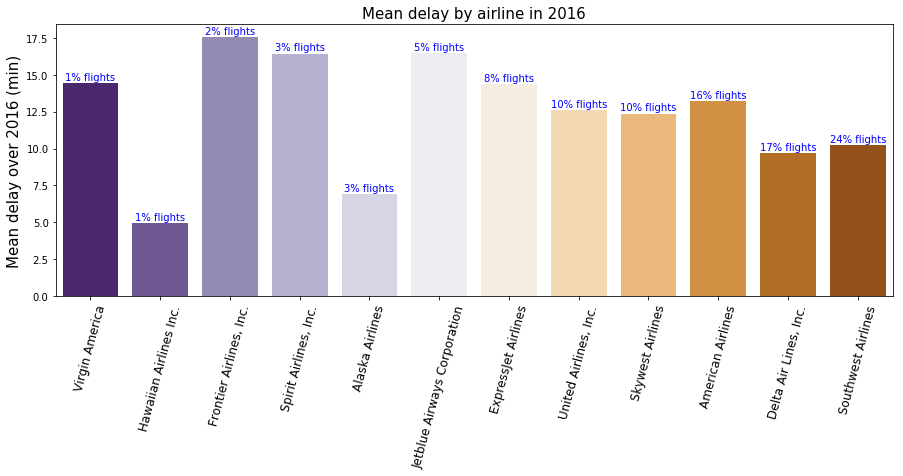

In [33]:
# Sort by flights descending
flights_df = flights_df.sort_values(by=['flights'], ascending=False)
# Save color palette from flights sort
flights_df['color'] = sns.color_palette("PuOr", flights_df.shape[0])
# Sort by flights ascending
flights_df = flights_df.sort_values(by=['flights'], ascending=True)
# Reindex for plotting
flights_df.index = np.arange(0,12,1)
# Plot
fig, ax = plt.subplots(figsize=(15,5))
g = sns.barplot(flights_df['flights'].index.values, flights_df['means'].values, palette=flights_df['color'].values)
ax.set_xticklabels(flights_df['names'].values, rotation=75, fontsize=12)
ax.set_ylabel("Mean delay over 2016 (min)", fontsize=15)
ax.set_title("Mean delay by airline in 2016", loc="center", fontsize=15)
# Add percentage of 2016 flights
for index, row in flights_df.iterrows():
    g.text(row.name, row.means+0.2, '{:.0%} {}'.format(row.flights_per, 'flights'), color='blue', ha='center');

It appears from those charts that on average some airlines present more delayed flights than others. However, some airlines are very small and account for much fewer flights than others.

Those different statistics would lead to think that _**a regression model for each airline may be more suitable to this DataSet.**_

Mean delay behaviour for 5 main arline in main airport

In [34]:
# Main airport ?
main_ap = data_2016_explo.loc[:, 'ORIGIN_AIRPORT_ID'].value_counts().index.values[0]
print("The most frequented airport is : %s" % airport_dict_name[main_ap])
# 5 most used airlines in this airport in 2016 ?
main_airlines = data_2016_explo.loc[:, 'UNIQUE_CARRIER'][data_2016_explo.loc[:, 'ORIGIN_AIRPORT_ID'] == main_ap].value_counts().head()
print("The most used airlines for %s in 2016 are : " % airport_dict_name[main_ap])
for airline, count in main_airlines.iteritems() :
    print("%-25s with %-6i flights in 2016" % (airlines_full_names[airline] + '({})'.format(airline), count))

The most frequented airport is : Atlanta, GA
The most used airlines for Atlanta, GA in 2016 are : 
Delta Air Lines, Inc.(DL) with 245511 flights in 2016
ExpressJet Airlines(EV)   with 48048  flights in 2016
Southwest Airlines(WN)    with 42369  flights in 2016
American Airlines(AA)     with 11383  flights in 2016
Spirit Airlines, Inc.(NK) with 7138   flights in 2016


In [35]:
import calendar
months = [month for month in calendar.month_name]
months.pop(0);

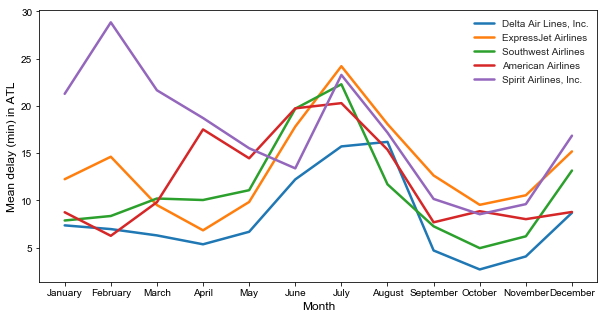

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
# Seaborn style
sns.set_style("white")
sns.set_context(font_scale=1.5, rc={"lines.linewidth": 2.5})
# Iterate over airlines
for airline, count in main_airlines.iteritems() :
    # Retrieve relevant data
    data_airline_airport = data_2016_explo[(data_2016_explo.loc[:, 'ORIGIN_AIRPORT_ID'] == main_ap) & 
                                           (data_2016_explo.loc[:, 'UNIQUE_CARRIER'] == airline)]
    mean_monthly_delay = data_airline_airport['ARR_DELAY_NEW'].groupby(data_airline_airport['MONTH']).apply(lambda x : x.mean())
    # Plot monthly mean delay
    ax.plot(months, mean_monthly_delay.values, label=airlines_full_names[airline])

ax.legend()
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Mean delay (min) in %s' % airport_dict[main_ap], fontsize=12);

In [37]:
cum_sum_df = pd.DataFrame()
# Iterate over airlines
count_pos = -2
for airline, count in main_airlines.iteritems() :
    temp_cum_sum_df = pd.DataFrame()
    # Retrieve relevant data
    data_airline_airport = data_2016_explo[(data_2016_explo.loc[:, 'ORIGIN_AIRPORT_ID'] == main_ap) & 
                                           (data_2016_explo.loc[:, 'UNIQUE_CARRIER'] == airline)]
    cum_monthly_delay = data_airline_airport['ARR_DELAY_NEW'].groupby(data_airline_airport['MONTH']).sum().cumsum()
    temp_cum_sum_df['month'] = cum_monthly_delay.index.values
    temp_cum_sum_df['cum_delay'] = cum_monthly_delay.apply(lambda x : x/60) 
    temp_cum_sum_df['airline'] = airline
    temp_cum_sum_df['pos_text'] = count_pos / 5
    
    cum_sum_df = pd.concat((cum_sum_df, temp_cum_sum_df))
    
    count_pos += 1
    
# Replace NaN of January with 0
cum_sum_df = cum_sum_df.fillna(0)

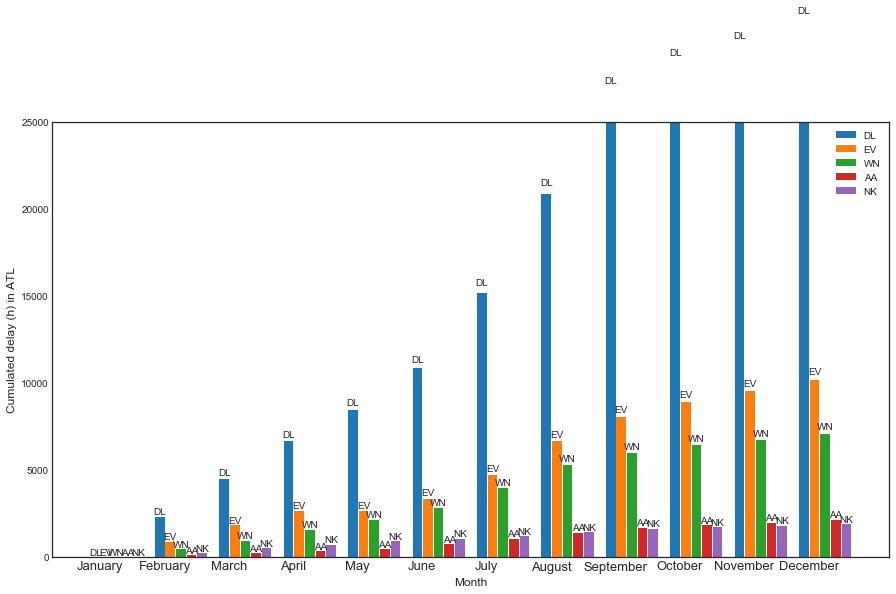

In [38]:
def autolabel(bps, label):
    """
    Attach a text label above each bar displaying a label
    """
    for bp in bps:
        height = bp.get_height()
        ax.text(bp.get_x() + bp.get_width()/2., 1.02*height, '%s' % label, ha='center', va='bottom', fontsize=10)

# Number of x abscisses
N = cum_sum_df.month.unique().shape[0]

ind = np.arange(N)  # the x locations for the months
width = 0.15       # the width of the bars

fig, ax = plt.subplots(figsize=(15,8))
# Seaborn style
sns.set_style("white")
sns.set_context(font_scale=1.5, rc={"lines.linewidth": 2.5})

mult_pos = 0
for airline in cum_sum_df.airline.unique() :
    # Plot monthly cumulated delay
    bp = ax.bar(ind + (width*1.1) * mult_pos, cum_sum_df[cum_sum_df.airline==airline].cum_delay, width, label=airline)
    # Loop
    mult_pos += 1
    # Insert airline name on bar
    autolabel(bp, airline)

ax.legend()
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(months, fontsize=13)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Cumulated delay (h) in %s' % airport_dict[main_ap], fontsize=12)
ax.set_ylim((0,25000));

Let's look at the delays themselves, over the full year

In [39]:
# Statistics
print("Median : %.2f" % data_2016_explo.loc[:, 'ARR_DELAY_NEW'].median(axis=0))
data_2016_explo.loc[:, 'ARR_DELAY_NEW'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

Median : 0.00


count    5.341242e+06
mean     1.188756e+01
std      3.827911e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.000000e+00
95%      6.600000e+01
99%      1.720000e+02
max      2.142000e+03
Name: ARR_DELAY_NEW, dtype: float64

The median is equal to zero, and the fourth quartile is at 7min of delay, therefore one can assume that most of the flights are on schedule ! That's a relief.
In order to not bias our model we should not give too much credit to the high delays which are most likely due to rare airplanes damage, or weather.

C:\Users\simon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


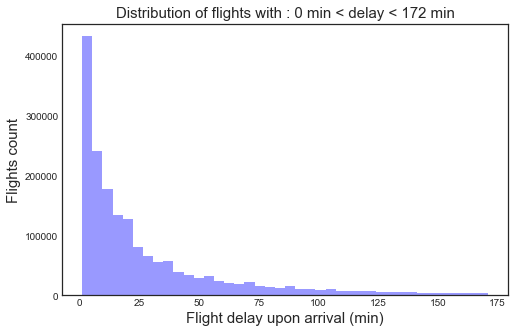

In [40]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(data_2016_explo.loc[:, 'ARR_DELAY_NEW'][(data_2016_explo.loc[:, 'ARR_DELAY_NEW'] > 0) & (data_2016_explo.loc[:, 'ARR_DELAY_NEW'] < 172)].values,
             kde=False,
             bins=40,
             color='b')
ax.set_xlabel("Flight delay upon arrival (min)", fontsize=15)
ax.set_ylabel("Flights count", fontsize=15)
ax.set_title("Distribution of flights with : 0 min < delay < 172 min", fontsize=15);

C:\Users\simon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


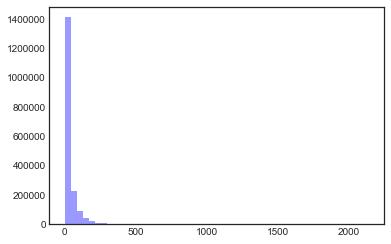

In [41]:
sns.distplot(data_2016_explo.loc[:, 'ARR_DELAY_NEW'][data_2016_explo.loc[:, 'ARR_DELAY_NEW'] > 0].values,
             kde=False,
             color='b')

From this distribution and the statistics we choose to select the delays inferiors to 140 minutes (2h20minutes)

In [42]:
# Set threshold
max_delay = 140
print("Shape before removing long delays : %i" % data_2016_explo.shape[0])
data_2016_explo = data_2016_explo[data_2016_explo.loc[:, 'ARR_DELAY_NEW'] <= max_delay]
print("Shape after removing long delays : %i" % data_2016_explo.shape[0])

Shape before removing long delays : 5341242
Shape after removing long delays : 5258789


Temporality of delays

In order to look for temporal patterns in delays, we will look for one airline and one airport, preferably major ones

In [43]:
# Select airline
airline_test = 'WN'
delay_datetime_df = data_2016_explo[data_2016_explo['UNIQUE_CARRIER'] == airline_test]

# Main airport for this airline
airport_test = delay_datetime_df.loc[:, 'ORIGIN_AIRPORT_ID'].value_counts().index[0]

print("Observing %s airline delays for %s airport" % (airlines_full_names[airline_test], airport_dict_name[airport_test]))

# Select main airport
delay_datetime_df = delay_datetime_df[delay_datetime_df['ORIGIN_AIRPORT_ID'] == airport_test]

# Sort delays by departure date
delay_datetime_df = delay_datetime_df.sort_values(by=['DATE_TIME'])

Observing Southwest Airlines airline delays for Chicago, IL airport


In [44]:
def time_delay_plot(df, month=None, week=None, day=None) :
    """
    Routine to plot delays as a function of departure time
    No safeguards
    """
    import calendar
    
    time_df = df.copy()
    # Select time window
    if (month == None) and (week == None) and (day == None) :
        pass
    if month is not None :
        n_days_month = calendar.monthrange(2016, month)[1]
        if month > 12 :
            return "ERROR : month must be <= 12"
        time_df = time_df[time_df['MONTH'] == month]
    if week is not None :
        if month is None :
            return "ERROR : must provide month with week"
        elif week > 5 :
            return "ERROR : week must be <= 5"
        # Day start
        day_start = (week - 1) * 7 + 1
        # Day end
        day_end = week * 7
        # End of month
        if day_end > n_days_month : day_end = n_days_month
        # Select days
        time_df = time_df[time_df['DAY_OF_MONTH'].isin(range(day_start, day_end + 1))]
    if day is not None :
        if month is None :
            return "ERROR : must provide month with day"
        elif day > n_days_month :
            return "ERROR : week must be <= n_days_month"
        time_df = time_df[time_df['DAY_OF_MONTH'] == day]

    # Plot everything
    time = time_df.loc[:, 'DATE_TIME']
    delays = time_df.loc[:, 'ARR_DELAY_NEW']
    
    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot(111)
    ax.scatter(time.values, delays.values, s=6)   
    ax.set_ylabel('Delay (min)', fontsize=15)
    ax.set_xlabel('Departure date and time', fontsize=15)
    ax.set_xlim((time.values.min(), time.values.max())); 
    
    df_return = pd.DataFrame(columns=["TIME", "DELAYS"])
    df_return["TIME"] = time
    df_return["DELAYS"] = delays
    
    return df_return

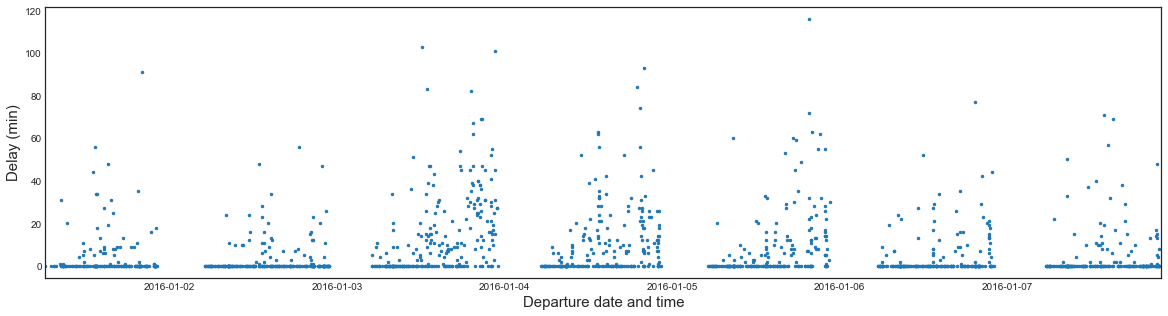

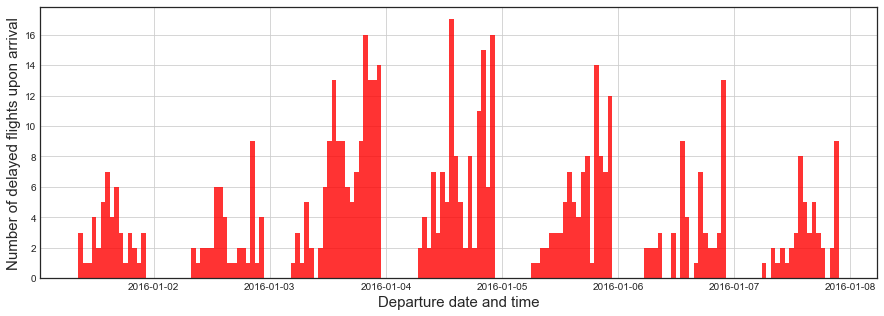

In [45]:
df_time = time_delay_plot(delay_datetime_df, month=1, week=1, day=None)
fig, ax = plt.subplots(figsize=(15,5))
df_time.loc[:, 'TIME'][df_time.DELAYS > 0].hist(color='r', bins=168, alpha=0.8)
ax.set_xlabel("Departure date and time", fontsize=15)
ax.set_ylabel("Number of delayed flights upon arrival", fontsize=15);

A time pattern appears quite clearly, at least during the day : delays tend to rise around noon and in the evening.

Plotting mean delay as a function of categorical features

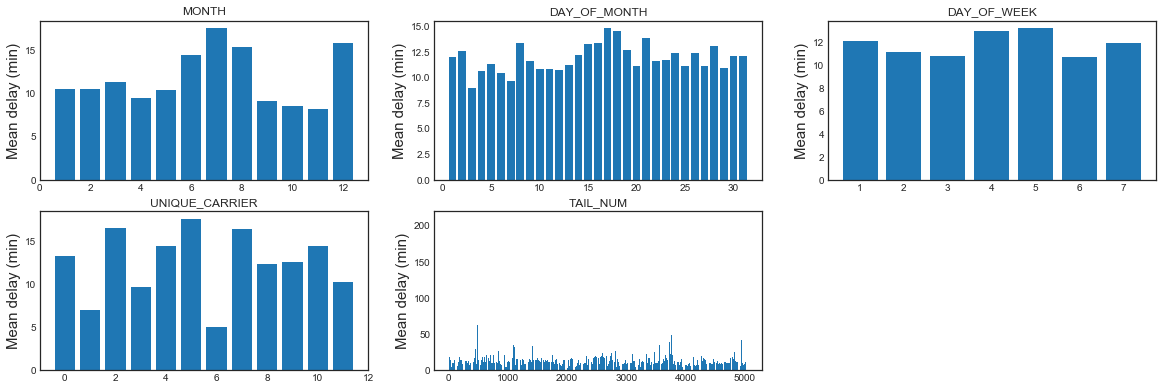

In [46]:
# plot mean delay by feature
fig = plt.figure(figsize=(20,45))

for feature, num in zip(categ_feat, range(1,len(categ_feat)-1)) :
    x_list = list(mean_delays_categ[feature][0])
    if isinstance(x_list[0], str) :
        le = preprocessing.LabelEncoder()
        x = le.fit_transform(x_list)
    else :
        x = x_list
    y = mean_delays_categ[feature][1]
    ax = fig.add_subplot(13,3,num)
    ax.bar(x, y)
    ax.set_title(feature)
    ax.set_ylabel('Mean delay (min)', fontsize=15)

Flight delays seem to be more related to month and carrier rather to the day of month or day of week

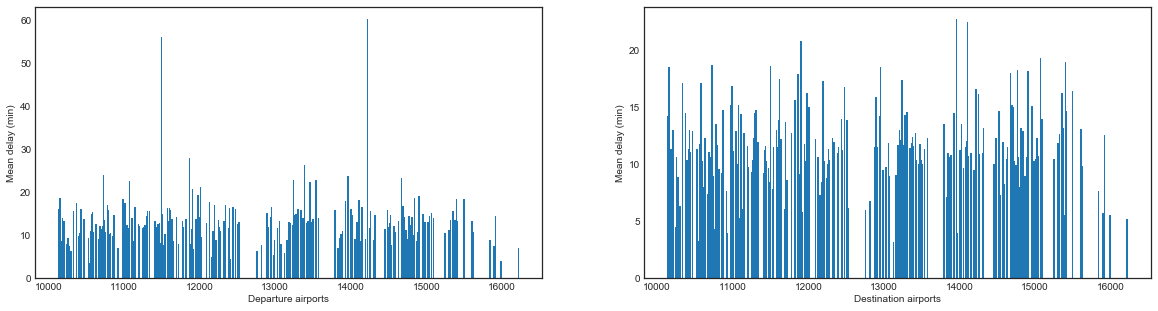

In [47]:
# plot bar charts for airports
fig = plt.figure(figsize=(20,5))
# Departure Airport
ax1 = fig.add_subplot(121)
ax1.bar(mean_delays_categ['ORIGIN_AIRPORT_ID'][0],mean_delays_categ['ORIGIN_AIRPORT_ID'][1], width=20)
ax1.set_ylabel("Mean delay (min)")
ax1.set_xlabel("Departure airports")
# Destination Airport
ax2 = fig.add_subplot(122)
ax2.bar(mean_delays_categ['DEST_AIRPORT_ID'][0],mean_delays_categ['DEST_AIRPORT_ID'][1], width=20);
ax2.set_ylabel("Mean delay (min)")
ax2.set_xlabel("Destination airports");

Some airports presents mean delays above the average

Plotting mean delay as a function of numerical features

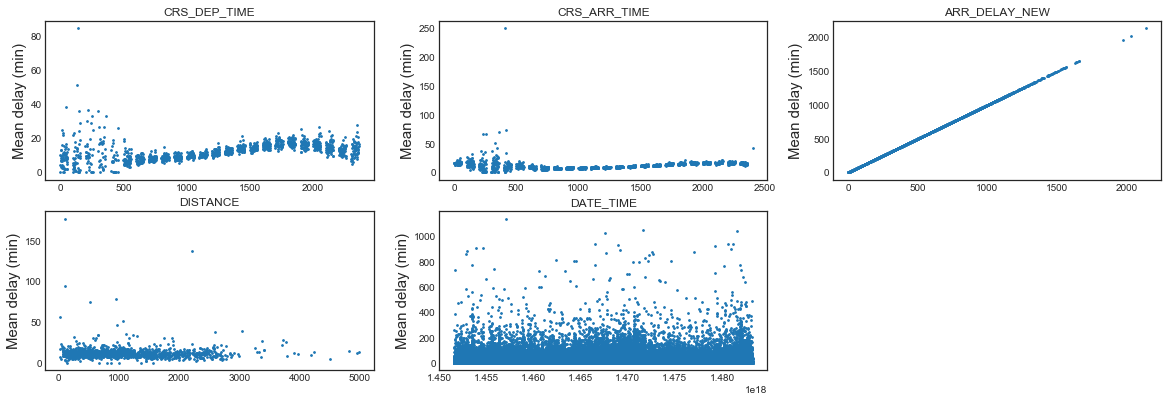

In [48]:
# plot mean delay by feature
fig = plt.figure(figsize=(20,45))

for feature, num in zip(num_feat, range(1,len(num_feat)+1)) :
    x_list = list(mean_delays_num[feature][0])
    if isinstance(x_list[0], str) :
        le = preprocessing.LabelEncoder()
        x = le.fit_transform(x_list)
    else :
        x = x_list
    y = mean_delays_num[feature][1]
    ax = fig.add_subplot(13,3,num)
    ax.scatter(x, y, s=3)
    ax.set_title(feature) 
    ax.set_ylabel('Mean delay (min)', fontsize=15)

Bulk year data are difficult to read, let's look to distance and scheduled departure time for our selected company and airport

Distance

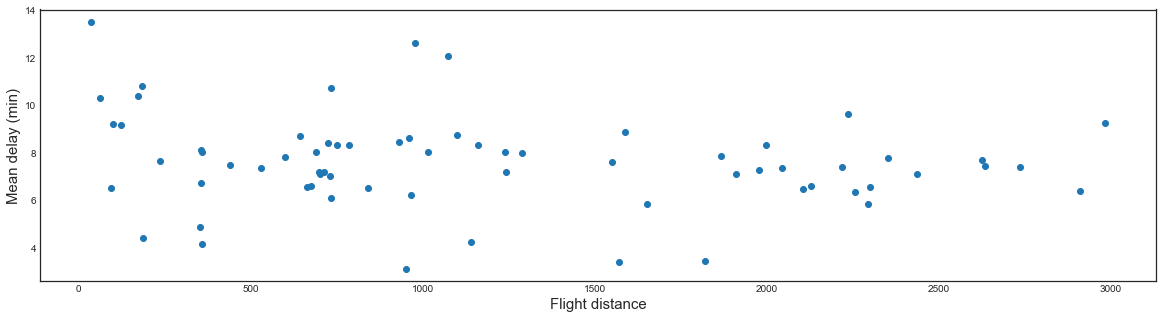

In [49]:
# Sub_df
distance_delays = delay_datetime_df.loc[:, ['DISTANCE', 'ARR_DELAY_NEW']]
# Distances
distances = distance_delays['DISTANCE'].value_counts()
# Remove too few flights
distances_ok = distances[distances >= 10]
# Select delays
distance_delays = distance_delays[distance_delays['DISTANCE'].isin(distances_ok.index.values)]
# Mean delay grouped by distance
distance_delay = distance_delays['ARR_DELAY_NEW'].groupby(distance_delays['DISTANCE']).apply(lambda x : x.mean())

# Plot
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.scatter(distances_ok, distance_delay);    
ax.set_ylabel('Mean delay (min)', fontsize=15)
ax.set_xlabel('Flight distance', fontsize=15);

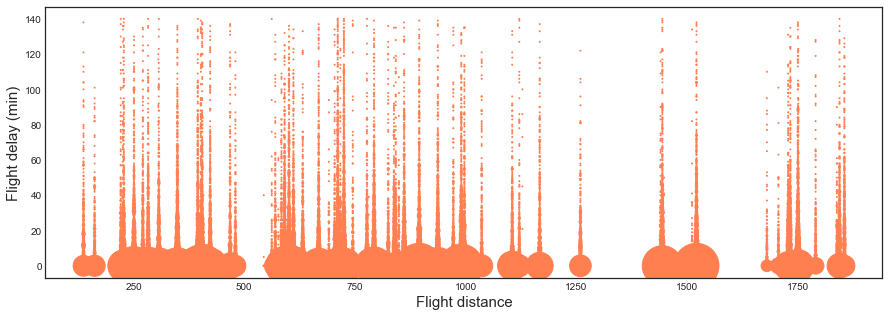

In [50]:
# Plot
fig, ax = plt.subplots(figsize=(15, 5))
sizes = {} # clé : coordonnées ; valeur : nombre de points à ces coordonnées
for (yt, yp) in zip(list(delay_datetime_df.loc[:, 'DISTANCE'].values), list(delay_datetime_df.loc[:, 'ARR_DELAY_NEW'].values)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1

keys = sizes.keys()
plt.scatter([k[0] for k in keys], # vraie valeur (abscisse)
            [k[1] for k in keys], # valeur predite (ordonnee)
            s=[sizes[k] for k in keys], # taille du marqueur
            color='coral');

ax.set_xlabel('Flight distance', fontsize=15)
ax.set_ylabel('Flight delay (min)', fontsize=15);

Flight distance does not seem to be an impacting factor on delays for this company and this departure airport

Schedule departure time of day : WRONG PLOTS : Day Of Week Different from one month to another

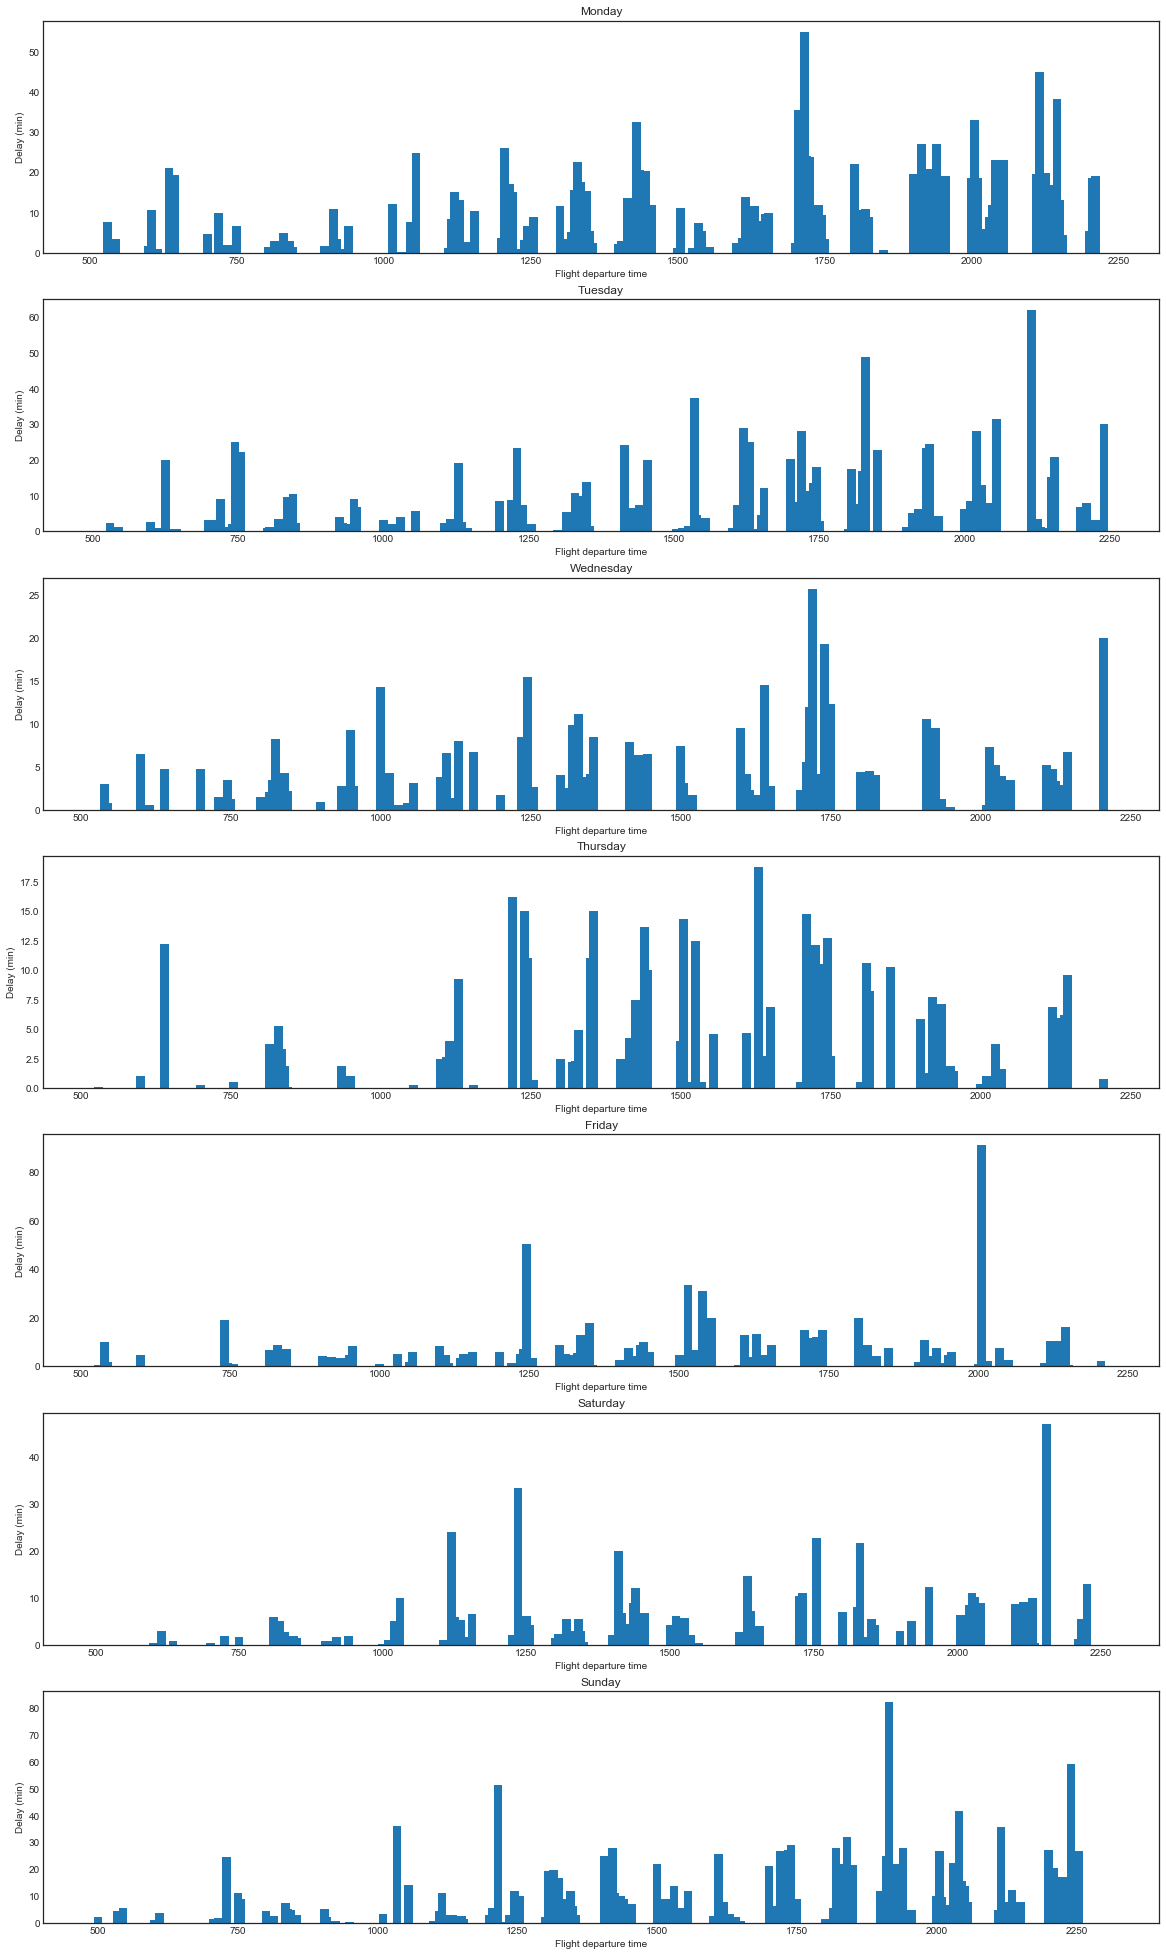

In [51]:
fig = plt.figure(figsize=(20, 35))

# January, each day of the week
days_of_week = [1,2,3,4,5,6,7]
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_dict = dict(zip(days_of_week, days))

for dow, num in zip(days_of_week, range(1, len(days_of_week) + 1)) :
    
    time_df = delay_datetime_df[(delay_datetime_df['MONTH'] == 1) & (delay_datetime_df['DAY_OF_WEEK'] == dow)]
    # Sub_df
    dep_time_delays = time_df.loc[:, ['CRS_DEP_TIME', 'ARR_DELAY_NEW']]
    # Distances
    dep_times = dep_time_delays['CRS_DEP_TIME'].value_counts()
    # Mean delay grouped by distance
    dep_time_delay = dep_time_delays['ARR_DELAY_NEW'].groupby(dep_time_delays['CRS_DEP_TIME']).apply(lambda x : x.mean())
    
    ax = fig.add_subplot(7, 1, num)
    ax.bar(dep_time_delay.index.values, dep_time_delay.values, width=15);
    # Day ?
    day = days_dict[dow]
    ax.set_title(day)
    ax.set_ylabel('Delay (min)')
    ax.set_xlabel('Flight departure time');

On most days of week the delay seems to rise as the scheduled departure time is late in the day, as one might have been expected delays tend to accumulate during the day

Aircrafts

In [52]:
# Construct dictionnary of aicrafts names encoded for later use
aircrafts_le = preprocessing.LabelEncoder()
# Get aircrafts names
aircrafts_names = data_2016_explo.loc[:,'TAIL_NUM'].value_counts().index.values
# Get aircrafts encoded values
aircrafts_number = aircrafts_le.fit_transform(aircrafts_names)
# Save dict
aircrafts_num_dict = dict(zip(aircrafts_number, aircrafts_names))
aircrafts_name_dict = dict(zip(aircrafts_names, aircrafts_number))

In [53]:
# Converting aircrafts name into number
delay_datetime_df.loc[:, 'AIRCRAFT_ID'] = delay_datetime_df.loc[:, 'TAIL_NUM'].apply(lambda x : aircrafts_name_dict[x])

In [54]:
# Sub_df
aircrafts_delays = delay_datetime_df.loc[:, ['AIRCRAFT_ID', 'ARR_DELAY_NEW']]
# Aircrafts
aircrafts = aircrafts_delays['AIRCRAFT_ID'].value_counts()
# Remove too few flights
aircrafts_ok = aircrafts[aircrafts >= 10]
# Select delays
aircrafts_delays = aircrafts_delays[aircrafts_delays['AIRCRAFT_ID'].isin(aircrafts_ok.index.values)]
# Mean delay grouped by aircraft
aircrafts_delay = aircrafts_delays['ARR_DELAY_NEW'].groupby(aircrafts_delays['AIRCRAFT_ID']).apply(lambda x : x.mean())

C:\Users\simon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


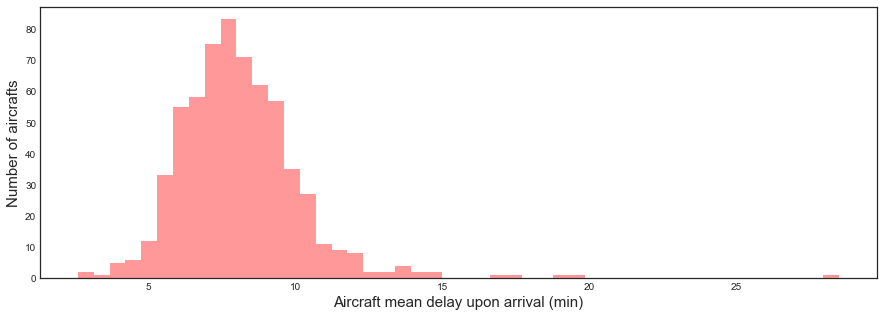

In [55]:
# Plot
fig, ax = plt.subplots(figsize=(15, 5))
sns.distplot(aircrafts_delay, kde=False, color='r')
ax.set_xlabel('Aircraft mean delay upon arrival (min)', fontsize=15)
ax.set_ylabel('Number of aircrafts', fontsize=15);

For this particular airline and airport, the distribution of delayed aircraft follows a normal law centered around 8 minutes

Deleting features that we won't use in the regression model :

* Month : as we only have data over 1 year, the month feature is not usefull as we will predict the future based on the past.
* Day of month and day of week : those did not seem to have a major impact over delays, at least on a global scale.
* Origin : we will only use the origin airport id
* Departure and Arrival time : we will keep the converted times in seconds

# 5) Exporting data

In [ ]:
keep_features = ['UNIQUE_CARRIER', 'ORIGIN', 'TIME_SECONDS', 'ARR_DELAY_NEW']
# Saving all air data for API
data_2016_explo.loc[:, keep_features].to_csv(path + '/data/air_data.csv', index=False)
# with open(path + '/data/air_data.pkl', 'wb') as f :  
#     pickle.dump(data_2016_explo.loc[:, keep_features], f)

In [ ]:
# Saving airlines and airports for API
airlines = data_2016_explo.loc[:, 'UNIQUE_CARRIER'].unique()
al_ap_df = pd.DataFrame()
for airline in airlines :
    al_ap_df = pd.concat((al_ap_df, pd.Series(data_2016_explo.loc[:, 'ORIGIN'][data_2016_explo.loc[:, 'UNIQUE_CARRIER'] == airline].unique())), axis=1)
al_ap_df.columns = airlines
# Save
al_ap_df.to_csv(path + '/data/airlines_airports.csv', index=False)
# with open(path + '/data/airlines_airports.pkl', 'wb') as f :  
#     pickle.dump(al_ap_df, f)

# 5.1.1) Exporting data for 2016, all airports, all airlines

In [ ]:
data_2016_final = data_2016_explo.drop(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'TAIL_NUM', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DISTANCE', 'DEST_AIRPORT_ID'], axis=1)

Save data for regression

In [ ]:
# Saving the dataframe with pickle : saving lots of time and keeping 'DATE_TIME' in date format and not string
with open(path + '/data/data_airlines.pkl', 'wb') as f :  
    pickle.dump(data_2016_final, f)

# 5.1.2) Exporting data for 2016, all airports, all airlines, more features

In [ ]:
data_temp = data_2016_explo.drop(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'CRS_DEP_TIME', 'CRS_ARR_TIME'], axis=1)

Save data for regression

In [ ]:
# Saving the dataframe with pickle : saving lots of time and keeping 'DATE_TIME' in date format and not string
with open(path + '/data/data_more_features.pkl', 'wb') as f :  
    pickle.dump(data_temp, f)

# 5.2) Exporting data for 2016, one airport, all airlines

Selecting data for the main airport we have at our disposal

In [86]:
# Main airport by number of flights
main_airport = data_2016_explo.loc[:, 'ORIGIN_AIRPORT_ID'].value_counts().index[0]
flights_main_airport = data_2016_explo.loc[:, 'ORIGIN_AIRPORT_ID'].value_counts().values[0]
print("main airport : %s with %i flights in 2016" % (airport_dict_name[main_airport],flights_main_airport))

main airport : Atlanta, GA with 366245 flights in 2016


In [87]:
data_2016_1_aiport = data_2016_explo[data_2016_explo.loc[:, 'ORIGIN_AIRPORT_ID'] == main_airport]
data_2016_1_aiport = data_2016_1_aiport.drop(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN',
                                              'CRS_DEP_TIME', 'CRS_ARR_TIME', 'ORIGIN_AIRPORT_ID',
                                              'DEST_AIRPORT_ID', 'DATE_TIME'], axis=1)

Save data for regression

In [88]:
# Saving the dataframe with pickle : saving lots of time and keeping 'DATE_TIME' in date format and not string
with open(path + '/data/data_2016_1_aiport.pkl', 'wb') as f :  
    pickle.dump(data_2016_1_aiport, f)

# 5.3.1) Exporting data for 2016, one airport, one airline

Selecting data for the main airline and main airport for this airline we have at our disposal

In [93]:
# Select airline
main_airline = 'WN'
data_2016_1_airline_1_aiport = data_2016_explo[data_2016_explo['UNIQUE_CARRIER'] == main_airline]
# Main airport for this airline by number of flights
main_airport = data_2016_1_airline_1_aiport.loc[:, 'ORIGIN_AIRPORT_ID'].value_counts().index[0]
flights_main_airport = data_2016_1_airline_1_aiport.loc[:, 'ORIGIN_AIRPORT_ID'].value_counts().values[0]
print("Main airport : %s with %i flights in 2016 for %s airline" % (airport_dict_name[main_airport], flights_main_airport, airlines_full_names[main_airline]))

Main airport : Chicago, IL with 80917 flights in 2016 for Southwest Airlines airline


In [94]:
data_2016_1_airline_1_aiport = data_2016_1_airline_1_aiport[data_2016_1_airline_1_aiport.loc[:, 'ORIGIN_AIRPORT_ID'] == main_airport]
data_2016_1_airline_1_aiport = data_2016_1_airline_1_aiport.drop(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN',
                                                                  'CRS_DEP_TIME', 'CRS_ARR_TIME', 'UNIQUE_CARRIER',
                                                                  'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DATE_TIME'], axis=1)

Save data for regression

In [95]:
# Saving the dataframe with pickle : saving lots of time and keeping 'DATE_TIME' in date format and not string
with open(path + '/data/data_2016_1_airline_1_aiport.pkl', 'wb') as f :  
    pickle.dump(data_2016_1_airline_1_aiport, f)

# 5.3.2) Exporting data for 2016, one airport, one airline with date_time for prophet

Selecting data for the main airline and main airport for this airline we have at our disposal

In [59]:
# Select airline
main_airline = 'WN'
data_2016_1_airline_1_aiport_prophet = data_2016_explo[data_2016_explo['UNIQUE_CARRIER'] == main_airline]
# Main airport for this airline by number of flights
main_airport = data_2016_1_airline_1_aiport_prophet.loc[:, 'ORIGIN_AIRPORT_ID'].value_counts().index[0]
flights_main_airport = data_2016_1_airline_1_aiport_prophet.loc[:, 'ORIGIN_AIRPORT_ID'].value_counts().values[0]
print("Main airport : %s with %i flights in 2016 for %s airline" % (airport_dict_name[main_airport], flights_main_airport, airlines_full_names[main_airline]))

Main airport : Chicago, IL with 80917 flights in 2016 for Southwest Airlines airline


In [60]:
data_2016_1_airline_1_aiport_prophet = data_2016_1_airline_1_aiport_prophet[data_2016_1_airline_1_aiport_prophet.loc[:, 'ORIGIN_AIRPORT_ID'] == main_airport]
data_2016_1_airline_1_aiport_prophet = data_2016_1_airline_1_aiport_prophet.drop(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN',
                                                                  'CRS_DEP_TIME', 'CRS_ARR_TIME', 'UNIQUE_CARRIER',
                                                                  'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID'], axis=1)

Save data for regression

In [61]:
# Saving the dataframe with pickle : saving lots of time and keeping 'DATE_TIME' in date format and not string
with open(path + '/data/data_2016_1_airline_1_aiport_prophet.pkl', 'wb') as f :  
    pickle.dump(data_2016_1_airline_1_aiport_prophet, f)

# 5.4) Exporting data for 2016, all airports, one airline

Selecting data for the main airline we have at our disposal

In [96]:
# Select airline
main_airline = 'WN'
data_2016_1_airline = data_2016_explo[data_2016_explo['UNIQUE_CARRIER'] == main_airline]

In [98]:
data_2016_1_airline = data_2016_1_airline.drop(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN',
                                                'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DATE_TIME',
                                                'UNIQUE_CARRIER', 'DEST_AIRPORT_ID'], axis=1)

Save data for regression

In [99]:
# Saving the dataframe with pickle : saving lots of time and keeping 'DATE_TIME' in date format and not string
with open(path + '/data/data_2016_1_airline.pkl', 'wb') as f :  
    pickle.dump(data_2016_1_airline, f)

# 6) Group data by aircraft, taking into account the aircraft's history

In [ ]:
# To be done